Julianna Godziszewska, st126128

## Task 2: Fully Convolutional Network (FCN)

Implement an FCN for semantic segmentation, train it on a small dataset, and analyze how architectural and training choices affect performance.

**Instructions:**

**Dataset**:    
- Use a subset of Pascal VOC, COCO, or a small custom dataset (10–20 images for quick runs).
- Split into train/test.
- Preprocess (resize, normalize, and convert masks to class indices).
**Model Implementation**:    
- Implement FCN-32s, FCN-16s, or FCN-8s variants.
- Use pretrained ResNet/VGG (remove final FC layers) as a backbone
- Upsampling Method: 1) transpose convolution vs 2) bilinear interpolation.     
**Training**:              
- Loss: CrossEntropyLoss
- Optimizer: Adam or SGD
- Metrics: Mean IoU, pixel accuracy
- Train for 20 epochs (or until convergence).
- Log training curves.

**Deliverable:**

- Jupyter notebook with clear code and comments.
- Visualization of segmentation results (min. 3 test images).
- Table comparing transpose convolution vs bilinear interpolation.
- Summarize with visuals and short analysis.

In [50]:
import os
from pathlib import Path
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as T
from tqdm import tqdm 

from PIL import Image
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt

Dataset: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset (VOC2012_trainval)

In [51]:
VOC_ROOT = Path('VOC2012_train_val')
IMAGE_DIR = VOC_ROOT / 'JPEGImages'
MASK_DIR = VOC_ROOT / 'SegmentationClass'
ID_LIST_PATH = VOC_ROOT / 'ImageSets' / 'Segmentation' / 'trainval.txt'
IMAGE_SIZE = (256, 256) 
NUM_CLASSES = 21 #20 classes + background
RANDOM_SEED = 2 
DATASET_LIMIT = 100

# Dataset preprocessing and data split

In [52]:
#20 classes is to much fro small dataset, so we will group similar classes together to reduce number of classes

NUM_CLASSES = 5 

VOC_REMAPPING = {
    # 0: Background

    # 1: Vehicles
    1: 1,  # aeroplane
    2: 1,  # bicycle
    6: 1,  # bus
    7: 1,  # car
    14: 1, # motorbike
    19: 1, # train
    4: 1,  # boat  (brakowało!)

    # 2: People
    15: 2, # person

    # 3: Animals
    3: 3,  # bird
    8: 3,  # cat
    10: 3, # cow
    12: 3, # dog
    13: 3, # horse
    17: 3, # sheep

    # 4: Objects
    5: 4,  # bottle
    9: 4,  # chair
    11: 4, # diningtable
    16: 4, # pottedplant
    18: 4, # sofa
    20: 4, # tvmonitor
}


def remap_mask(mask: torch.Tensor) -> torch.Tensor:
    """
    Remaps 21 PASCAL VOC classes to 5 generalized classes (0-4).
    """
   
    new_mask = mask.clone().to(torch.long)
    new_mask[new_mask == 255] = 0 
    
    final_mask = torch.zeros_like(new_mask, dtype=torch.long)
    final_mask[new_mask == 0] = 0

    for original_id, new_id in VOC_REMAPPING.items():
        final_mask[new_mask == original_id] = new_id
        
    return final_mask

In [53]:
NUM_CLASSES = 5
final_ids = []
try:
    # Take first x images
    with open(ID_LIST_PATH, 'r') as f:
        all_ids = [line.strip() for line in f.readlines()]
    
    final_ids = all_ids[:DATASET_LIMIT]

except FileNotFoundError:
    print(f"FATAL ERROR: Official VOC ID list not found at {ID_LIST_PATH}. Cannot load data.")
    
except Exception as e:
    print(f"FATAL ERROR during ID loading: {e}")

if not final_ids:
    print("Cannot proceed without image IDs.")

# Split data into train and test
if final_ids:
    train_ids, val_test_ids = train_test_split(
        final_ids, 
        test_size=0.3,      
        random_state=RANDOM_SEED
    )

    val_ids, test_ids = train_test_split(
        val_test_ids, 
        test_size=0.5,     
        random_state=RANDOM_SEED
    )

    print(f"\nFinal images selected automatically: {len(final_ids)}")
    print(f"Train set size: {len(train_ids)}")
    print(f"Val set size: {len(val_ids)}")
    print(f"Test set size: {len(test_ids)}")


    # Load image masks
    class PascalVOCDataset(Dataset):
        """Custom PyTorch Dataset for loading image and mask pairs from PASCAL VOC."""
        def __init__(self, ids_list, img_dir, mask_dir, transform=None, target_transform=None):
            self.ids_list = ids_list
            self.img_dir = Path(img_dir)
            self.mask_dir = Path(mask_dir)
            self.transform = transform
            self.target_transform = target_transform

        def __len__(self):
            return len(self.ids_list)

        def __getitem__(self, idx):
            img_id = self.ids_list[idx]
            
            img_path = self.img_dir / f'{img_id}.jpg'
            mask_path = self.mask_dir / f'{img_id}.png'
            
            image = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path) 

            if self.transform:
                image = self.transform(image)
                
            if self.target_transform:
                mask = self.target_transform(mask)
                
            mask = torch.as_tensor(np.array(mask), dtype=torch.long)
            mask = remap_mask(mask)
            
            return image, mask

    # Preprocess data

    image_transform = T.Compose([
        T.Resize(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

    target_transform = T.Compose([
        T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.NEAREST), 
    ])

    # Dataloaders
    
    train_dataset = PascalVOCDataset(
        ids_list=train_ids,
        img_dir=IMAGE_DIR,
        mask_dir=MASK_DIR,
        transform=image_transform,
        target_transform=target_transform
    )

    test_dataset = PascalVOCDataset(
        ids_list=test_ids,
        img_dir=IMAGE_DIR,
        mask_dir=MASK_DIR,
        transform=image_transform,
        target_transform=target_transform
    )

    val_dataset = PascalVOCDataset(
        ids_list=val_ids, 
        img_dir=IMAGE_DIR,
        mask_dir=MASK_DIR,
        transform=image_transform,
        target_transform=target_transform
    )

    BATCH_SIZE = 4
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
else:
    print("\nInitialization failed. Please check the VOC_ROOT path.")


Final images selected automatically: 100
Train set size: 70
Val set size: 15
Test set size: 15


### Class distribution - to make sure all classes exists in each dataset

In [54]:
def check_class_distribution(dataloader, name, max_class_id=4):
    """
    Checks the unique class indices present in the entire dataset.
    """
    unique_classes = set()
    total_masks = 0
    
    try:
        for images, masks in dataloader:
            unique_classes.update(masks.unique().tolist())
            total_masks += masks.size(0)

        # Filtrujemy tylko klasy, które są w oczekiwanym zakresie (0 do 4)
        found_mapped_classes = sorted([c for c in unique_classes if c <= max_class_id])
    
        unexpected_classes = sorted([c for c in unique_classes if c > max_class_id and c != 255])
        
        print(f"\n--- Class Distribution Report: {name} ---")
        print(f"Total masks analyzed: {total_masks}")
        print(f"Found MAPPED class indices (0 - {max_class_id}): {found_mapped_classes}")
        
        if unexpected_classes:
            print(f"CRITICAL WARNING: Found UNMAPPED, unexpected classes > {max_class_id}: {unexpected_classes}")
            
        if 255 in unique_classes:
            print("WARNING: Class 255 (Unlabeled/Boundary) is present in masks.")
            
        print(f"Number of unique classes found (0-{max_class_id}): {len(found_mapped_classes)}")

    except FileNotFoundError:
        print(f"\nERROR: Cannot check distribution for {name}. Files not found during loading.")
    except Exception as e:
        print(f"\nERROR checking distribution for {name}: {e}")
        
print("\n--- Starting Data Analysis ---")
check_class_distribution(train_dataloader, "Training Set", max_class_id=4)
check_class_distribution(val_dataloader, "Validation Set", max_class_id=4)
check_class_distribution(test_dataloader, "Test Set", max_class_id=4)


--- Starting Data Analysis ---

--- Class Distribution Report: Training Set ---
Total masks analyzed: 70
Found MAPPED class indices (0 - 4): [0, 1, 2, 3, 4]
Number of unique classes found (0-4): 5

--- Class Distribution Report: Validation Set ---
Total masks analyzed: 15
Found MAPPED class indices (0 - 4): [0, 1, 2, 3, 4]
Number of unique classes found (0-4): 5

--- Class Distribution Report: Test Set ---
Total masks analyzed: 15
Found MAPPED class indices (0 - 4): [0, 1, 2, 3, 4]
Number of unique classes found (0-4): 5


# Model implementation: FCN-32 with ResNet backbone

In [55]:
def _bilinear_kernel(num_classes, kernel_size, stride):
    """
    Generates the weight tensor required to initialize nn.ConvTranspose2d 
    as a Bilinear Upsampling filter. This initialization provides a stable, 
    non-random starting point for the optimizer, leading to faster and more 
    reliable convergence compared to using random weights.
    """
    factor = (kernel_size + 1) // 2
    center = kernel_size / 2 - 0.5 if kernel_size % 2 == 1 else kernel_size / 2 - 1
    og = np.ogrid[:kernel_size, :kernel_size]
    kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    
    # Create the weight tensor (C_out, C_in, H, W)
    weights = torch.zeros(num_classes, num_classes, kernel_size, kernel_size)
    for i in range(num_classes):
        weights[i, i] = torch.from_numpy(kernel)
    return weights

def get_resnet_backbone():
    backbone = models.resnet50(weights='IMAGENET1K_V1')
    return backbone

class FCNBase(nn.Module):
    def __init__(self, num_classes=21, upsampling='bilinear'):
        super().__init__()
        self.upsampling = upsampling
        
        backbone = models.resnet50(weights='IMAGENET1K_V1') 
        
        # Layer 0: Conv1, BatchNorm, ReLU, MaxPool (Stride 4, 64 ch)
        self.layer0 = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool
        )
        
        # Layer 1: ResNet Layer 1 (Stride 4, 256 ch)
        self.layer1_pool = backbone.layer1 
        
        # Layer 2: ResNet Layer 2 (Stride 8, 512 ch) 
        self.layer2_pool = backbone.layer2 
        
        # Layer 3: ResNet Layer 3 (Stride 16, 1024 ch) 
        self.layer3_pool = backbone.layer3 
        
        # Layer 4: ResNet Layer 4 (Stride 32, 2048 ch) 
        self.layer4_pool = backbone.layer4
        
        # Classifier (1x1 Conv) 
        self.classifier = nn.Conv2d(2048, num_classes, kernel_size=1)

    def upsample(self, x, scale):
        return F.interpolate(x, scale_factor=scale, mode='bilinear', align_corners=False)

    def forward(self, x):
   
        x = self.layer0(x)
        x = self.layer1_pool(x)
        
        f3 = self.layer2_pool(x) 
        f4 = self.layer3_pool(f3) 
        f5 = self.layer4_pool(f4) 
        
        score_32s = self.classifier(f5)
        
        return score_32s, f4, f3


class FCN32s(FCNBase):
    def __init__(self, num_classes=21, upsampling='bilinear'):
        super().__init__(num_classes, upsampling)
        
        if upsampling == 'transpose':
            scale = 32
            kernel_size = 2 * scale
            padding = scale // 2
            
            self.final_upsample = nn.ConvTranspose2d(
                num_classes, num_classes,
                kernel_size=kernel_size, 
                stride=scale,
                padding=padding, 
                output_padding=scale % 2, 
                bias=False
            )
            
            # Billinear kernel initialization
            self.final_upsample.weight.data.copy_(_bilinear_kernel(
                num_classes, 
                kernel_size, 
                scale
            ))

    def forward(self, x):
        # forward pass from FCNBase
        score, _, _ = super().forward(x) 
        
        if self.upsampling == 'transpose':
            return self.final_upsample(score)
        else:
            return self.upsample(score, 32)

# Training

In [56]:

def compute_metrics(pred, target, num_classes):
    """
    Computes Pixel Accuracy and Mean Intersection over Union (Mean IoU).
    """
    pred = pred.argmax(1) 
    ignore_mask = (target != 255)
    
    pred = pred[ignore_mask].flatten()
    target = target[ignore_mask].flatten()

    correct_pixels = (pred == target).sum().item()
    total_pixels = target.numel()
    pixel_accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0

    intersection = torch.zeros(num_classes, dtype=torch.long)
    union = torch.zeros(num_classes, dtype=torch.long)
    
    combined = target * num_classes + pred
    hist = torch.bincount(combined, minlength=num_classes**2).reshape(num_classes, num_classes)
    
    for c in range(num_classes):
        intersection[c] = hist[c, c]
        union[c] = hist[c, :].sum() + hist[:, c].sum() - hist[c, c]
    
    iou = intersection.float() / union.float()
    
    valid_iou = iou[union > 0]
    mean_iou = valid_iou.mean().item() if valid_iou.numel() > 0 else 0

    return pixel_accuracy, mean_iou


def train_and_evaluate_model(model_class, upsampling_method, optimizer_type, num_classes, 
                             train_loader, val_loader, epochs=20, lr=1e-4, model_name_key="temp_model"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class(num_classes=num_classes, upsampling=upsampling_method).to(device)

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError("Optimizer must be 'Adam' or 'SGD'")

    # Loss
    criterion = nn.CrossEntropyLoss(ignore_index=255) 

    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_iou': []}

    print(f"\n--- Starting Training for {model.__class__.__name__} ({upsampling_method} / {optimizer_type}) ---")

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)"):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item() * images.size(0)
            
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        
        # Evaluation on val dataset
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                
                outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
                
                total_val_loss += criterion(outputs, masks).item() * images.size(0)
                
                all_preds.append(outputs.cpu())
                all_targets.append(masks.cpu())

            avg_val_loss = total_val_loss / len(val_loader.dataset)
            
            preds_tensor = torch.cat(all_preds, dim=0)
            targets_tensor = torch.cat(all_targets, dim=0)
            
            pixel_acc, mean_iou = compute_metrics(preds_tensor, targets_tensor, num_classes)
            
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(pixel_acc)
            history['val_iou'].append(mean_iou)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {pixel_acc:.4f} | IoU: {mean_iou:.4f}")
        
    os.makedirs('FCN_models', exist_ok=True)
    save_path = f"FCN_models/{model_name_key}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to: {save_path}")
    
    return model, history

In [57]:

UPSCALE_METHODS = ['transpose', 'bilinear']
EPOCHS = 50 
OPTIMIZER = 'Adam'
name = "FCN-32s"
results = {}

    
for method in UPSCALE_METHODS:
    key = f"{name}_{method}"
    model_save_key = f"{name}_{method}" 
    
    model, history = train_and_evaluate_model(
        model_class=FCN32s,
        upsampling_method=method,
        optimizer_type=OPTIMIZER,
        num_classes=NUM_CLASSES,
        train_loader=train_dataloader,
        val_loader=val_dataloader,
        epochs=EPOCHS,
        model_name_key=model_save_key 
    )
    
    results[key] = history
    results[key]['model_name'] = name
    results[key]['method'] = method
    
    print(f"Finished {key}. Final IoU: {history['val_iou'][-1]:.4f}")


--- Starting Training for FCN32s (transpose / Adam) ---


Epoch 1/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 19.22it/s]


Epoch 1: Train Loss: 0.9904 | Val Loss: 0.6288 | Acc: 0.8083 | IoU: 0.3488


Epoch 2/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 19.45it/s]


Epoch 2: Train Loss: 0.4596 | Val Loss: 0.4462 | Acc: 0.8442 | IoU: 0.3801


Epoch 3/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.81it/s]


Epoch 3: Train Loss: 0.3435 | Val Loss: 0.4360 | Acc: 0.8246 | IoU: 0.3026


Epoch 4/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 20.12it/s]


Epoch 4: Train Loss: 0.2843 | Val Loss: 0.4474 | Acc: 0.8502 | IoU: 0.3902


Epoch 5/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.75it/s]


Epoch 5: Train Loss: 0.2438 | Val Loss: 0.4333 | Acc: 0.8480 | IoU: 0.3968


Epoch 6/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.62it/s]


Epoch 6: Train Loss: 0.2342 | Val Loss: 0.4017 | Acc: 0.8500 | IoU: 0.3833


Epoch 7/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.45it/s]


Epoch 7: Train Loss: 0.2146 | Val Loss: 0.4606 | Acc: 0.8286 | IoU: 0.3526


Epoch 8/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.08it/s]


Epoch 8: Train Loss: 0.2203 | Val Loss: 0.3917 | Acc: 0.8684 | IoU: 0.4615


Epoch 9/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.18it/s]


Epoch 9: Train Loss: 0.1916 | Val Loss: 0.5193 | Acc: 0.8330 | IoU: 0.3312


Epoch 10/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.99it/s]


Epoch 10: Train Loss: 0.1816 | Val Loss: 0.4295 | Acc: 0.8554 | IoU: 0.4172


Epoch 11/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.08it/s]


Epoch 11: Train Loss: 0.1643 | Val Loss: 0.4291 | Acc: 0.8483 | IoU: 0.4014


Epoch 12/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.40it/s]


Epoch 12: Train Loss: 0.1638 | Val Loss: 0.4120 | Acc: 0.8533 | IoU: 0.3691


Epoch 13/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.62it/s]


Epoch 13: Train Loss: 0.1605 | Val Loss: 0.4167 | Acc: 0.8555 | IoU: 0.4271


Epoch 14/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.51it/s]


Epoch 14: Train Loss: 0.1547 | Val Loss: 0.4346 | Acc: 0.8538 | IoU: 0.4117


Epoch 15/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.63it/s]


Epoch 15: Train Loss: 0.1473 | Val Loss: 0.4373 | Acc: 0.8566 | IoU: 0.4283


Epoch 16/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.46it/s]


Epoch 16: Train Loss: 0.1499 | Val Loss: 0.4732 | Acc: 0.8490 | IoU: 0.4156


Epoch 17/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.28it/s]


Epoch 17: Train Loss: 0.1447 | Val Loss: 0.4491 | Acc: 0.8482 | IoU: 0.4270


Epoch 18/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.21it/s]


Epoch 18: Train Loss: 0.1442 | Val Loss: 0.3874 | Acc: 0.8779 | IoU: 0.4902


Epoch 19/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.56it/s]


Epoch 19: Train Loss: 0.1382 | Val Loss: 0.4260 | Acc: 0.8637 | IoU: 0.4528


Epoch 20/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.71it/s]


Epoch 20: Train Loss: 0.1318 | Val Loss: 0.4163 | Acc: 0.8714 | IoU: 0.4593


Epoch 21/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.41it/s]


Epoch 21: Train Loss: 0.1347 | Val Loss: 0.4449 | Acc: 0.8584 | IoU: 0.4706


Epoch 22/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.50it/s]


Epoch 22: Train Loss: 0.1292 | Val Loss: 0.4189 | Acc: 0.8712 | IoU: 0.4733


Epoch 23/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.39it/s]


Epoch 23: Train Loss: 0.1252 | Val Loss: 0.4817 | Acc: 0.8590 | IoU: 0.4599


Epoch 24/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.14it/s]


Epoch 24: Train Loss: 0.1312 | Val Loss: 0.4195 | Acc: 0.8737 | IoU: 0.4884


Epoch 25/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.60it/s]


Epoch 25: Train Loss: 0.1270 | Val Loss: 0.4470 | Acc: 0.8672 | IoU: 0.4700


Epoch 26/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.78it/s]


Epoch 26: Train Loss: 0.1184 | Val Loss: 0.4821 | Acc: 0.8591 | IoU: 0.4539


Epoch 27/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.53it/s]


Epoch 27: Train Loss: 0.1188 | Val Loss: 0.4919 | Acc: 0.8577 | IoU: 0.4442


Epoch 28/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.58it/s]


Epoch 28: Train Loss: 0.1181 | Val Loss: 0.5130 | Acc: 0.8449 | IoU: 0.4015


Epoch 29/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.94it/s]


Epoch 29: Train Loss: 0.1174 | Val Loss: 0.4757 | Acc: 0.8574 | IoU: 0.4407


Epoch 30/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.45it/s]


Epoch 30: Train Loss: 0.1164 | Val Loss: 0.5300 | Acc: 0.8470 | IoU: 0.4039


Epoch 31/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.88it/s]


Epoch 31: Train Loss: 0.1153 | Val Loss: 0.4950 | Acc: 0.8600 | IoU: 0.4408


Epoch 32/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.48it/s]


Epoch 32: Train Loss: 0.1191 | Val Loss: 0.4816 | Acc: 0.8569 | IoU: 0.4516


Epoch 33/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.50it/s]


Epoch 33: Train Loss: 0.1155 | Val Loss: 0.4822 | Acc: 0.8543 | IoU: 0.4592


Epoch 34/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.83it/s]


Epoch 34: Train Loss: 0.1117 | Val Loss: 0.4881 | Acc: 0.8608 | IoU: 0.4620


Epoch 35/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.03it/s]


Epoch 35: Train Loss: 0.1121 | Val Loss: 0.4994 | Acc: 0.8552 | IoU: 0.4473


Epoch 36/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.62it/s]


Epoch 36: Train Loss: 0.1086 | Val Loss: 0.4933 | Acc: 0.8583 | IoU: 0.4442


Epoch 37/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 16.74it/s]


Epoch 37: Train Loss: 0.1084 | Val Loss: 0.4484 | Acc: 0.8668 | IoU: 0.4893


Epoch 38/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.58it/s]


Epoch 38: Train Loss: 0.1070 | Val Loss: 0.4948 | Acc: 0.8584 | IoU: 0.4528


Epoch 39/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.74it/s]


Epoch 39: Train Loss: 0.1059 | Val Loss: 0.5019 | Acc: 0.8603 | IoU: 0.4691


Epoch 40/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.17it/s]


Epoch 40: Train Loss: 0.1050 | Val Loss: 0.5002 | Acc: 0.8594 | IoU: 0.4591


Epoch 41/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.10it/s]


Epoch 41: Train Loss: 0.1024 | Val Loss: 0.5108 | Acc: 0.8581 | IoU: 0.4527


Epoch 42/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.90it/s]


Epoch 42: Train Loss: 0.1030 | Val Loss: 0.4992 | Acc: 0.8570 | IoU: 0.4562


Epoch 43/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.73it/s]


Epoch 43: Train Loss: 0.1019 | Val Loss: 0.4942 | Acc: 0.8634 | IoU: 0.4671


Epoch 44/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.58it/s]


Epoch 44: Train Loss: 0.1037 | Val Loss: 0.5245 | Acc: 0.8538 | IoU: 0.4337


Epoch 45/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.66it/s]


Epoch 45: Train Loss: 0.1020 | Val Loss: 0.4837 | Acc: 0.8625 | IoU: 0.4750


Epoch 46/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.82it/s]


Epoch 46: Train Loss: 0.1014 | Val Loss: 0.4966 | Acc: 0.8597 | IoU: 0.4691


Epoch 47/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.47it/s]


Epoch 47: Train Loss: 0.1001 | Val Loss: 0.4902 | Acc: 0.8615 | IoU: 0.4690


Epoch 48/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.84it/s]


Epoch 48: Train Loss: 0.0999 | Val Loss: 0.5400 | Acc: 0.8529 | IoU: 0.4486


Epoch 49/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.65it/s]


Epoch 49: Train Loss: 0.0993 | Val Loss: 0.5602 | Acc: 0.8526 | IoU: 0.4329


Epoch 50/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.90it/s]


Epoch 50: Train Loss: 0.0989 | Val Loss: 0.5358 | Acc: 0.8501 | IoU: 0.4435
Model weights saved to: FCN_models/FCN-32s_transpose.pth
Finished FCN-32s_transpose. Final IoU: 0.4435

--- Starting Training for FCN32s (bilinear / Adam) ---


Epoch 1/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.31it/s]


Epoch 1: Train Loss: 1.0618 | Val Loss: 0.5407 | Acc: 0.8349 | IoU: 0.4240


Epoch 2/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.42it/s]


Epoch 2: Train Loss: 0.4330 | Val Loss: 0.4355 | Acc: 0.8395 | IoU: 0.4438


Epoch 3/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.10it/s]


Epoch 3: Train Loss: 0.3220 | Val Loss: 0.4035 | Acc: 0.8365 | IoU: 0.4209


Epoch 4/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.12it/s]


Epoch 4: Train Loss: 0.3058 | Val Loss: 0.3692 | Acc: 0.8577 | IoU: 0.4732


Epoch 5/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.67it/s]


Epoch 5: Train Loss: 0.2468 | Val Loss: 0.4062 | Acc: 0.8444 | IoU: 0.4364


Epoch 6/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 16.36it/s]


Epoch 6: Train Loss: 0.2220 | Val Loss: 0.4190 | Acc: 0.8454 | IoU: 0.4401


Epoch 7/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.29it/s]


Epoch 7: Train Loss: 0.2071 | Val Loss: 0.4484 | Acc: 0.8447 | IoU: 0.4386


Epoch 8/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.50it/s]


Epoch 8: Train Loss: 0.2043 | Val Loss: 0.4219 | Acc: 0.8474 | IoU: 0.4454


Epoch 9/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 16.74it/s]


Epoch 9: Train Loss: 0.1786 | Val Loss: 0.4237 | Acc: 0.8471 | IoU: 0.4440


Epoch 10/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 16.98it/s]


Epoch 10: Train Loss: 0.1777 | Val Loss: 0.4271 | Acc: 0.8454 | IoU: 0.4142


Epoch 11/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.46it/s]


Epoch 11: Train Loss: 0.1695 | Val Loss: 0.4175 | Acc: 0.8514 | IoU: 0.4553


Epoch 12/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.79it/s]


Epoch 12: Train Loss: 0.1750 | Val Loss: 0.4091 | Acc: 0.8548 | IoU: 0.4715


Epoch 13/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.61it/s]


Epoch 13: Train Loss: 0.1587 | Val Loss: 0.4232 | Acc: 0.8552 | IoU: 0.4686


Epoch 14/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.24it/s]


Epoch 14: Train Loss: 0.1620 | Val Loss: 0.4201 | Acc: 0.8539 | IoU: 0.4701


Epoch 15/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.27it/s]


Epoch 15: Train Loss: 0.1469 | Val Loss: 0.4424 | Acc: 0.8482 | IoU: 0.4588


Epoch 16/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 15.51it/s]


Epoch 16: Train Loss: 0.1444 | Val Loss: 0.4392 | Acc: 0.8494 | IoU: 0.4529


Epoch 17/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.70it/s]


Epoch 17: Train Loss: 0.1387 | Val Loss: 0.4173 | Acc: 0.8567 | IoU: 0.4778


Epoch 18/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.80it/s]


Epoch 18: Train Loss: 0.1439 | Val Loss: 0.4446 | Acc: 0.8529 | IoU: 0.4619


Epoch 19/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.12it/s]


Epoch 19: Train Loss: 0.1467 | Val Loss: 0.4530 | Acc: 0.8461 | IoU: 0.4295


Epoch 20/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.03it/s]


Epoch 20: Train Loss: 0.1446 | Val Loss: 0.4226 | Acc: 0.8553 | IoU: 0.4763


Epoch 21/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.80it/s]


Epoch 21: Train Loss: 0.1713 | Val Loss: 0.4552 | Acc: 0.8534 | IoU: 0.4666


Epoch 22/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.11it/s]


Epoch 22: Train Loss: 0.1544 | Val Loss: 0.4135 | Acc: 0.8698 | IoU: 0.5020


Epoch 23/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.68it/s]


Epoch 23: Train Loss: 0.1446 | Val Loss: 0.4430 | Acc: 0.8508 | IoU: 0.4518


Epoch 24/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.06it/s]


Epoch 24: Train Loss: 0.1429 | Val Loss: 0.4474 | Acc: 0.8518 | IoU: 0.4336


Epoch 25/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.89it/s]


Epoch 25: Train Loss: 0.1355 | Val Loss: 0.4928 | Acc: 0.8408 | IoU: 0.4124


Epoch 26/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.18it/s]


Epoch 26: Train Loss: 0.1330 | Val Loss: 0.5179 | Acc: 0.8451 | IoU: 0.4506


Epoch 27/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.67it/s]


Epoch 27: Train Loss: 0.1382 | Val Loss: 0.4994 | Acc: 0.8509 | IoU: 0.4709


Epoch 28/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.74it/s]


Epoch 28: Train Loss: 0.1323 | Val Loss: 0.4893 | Acc: 0.8487 | IoU: 0.4567


Epoch 29/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.68it/s]


Epoch 29: Train Loss: 0.1413 | Val Loss: 0.5524 | Acc: 0.8510 | IoU: 0.4548


Epoch 30/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.90it/s]


Epoch 30: Train Loss: 0.1485 | Val Loss: 0.4571 | Acc: 0.8622 | IoU: 0.4907


Epoch 31/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.10it/s]


Epoch 31: Train Loss: 0.1385 | Val Loss: 0.5190 | Acc: 0.8342 | IoU: 0.4148


Epoch 32/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.73it/s]


Epoch 32: Train Loss: 0.1300 | Val Loss: 0.5110 | Acc: 0.8472 | IoU: 0.4433


Epoch 33/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.20it/s]


Epoch 33: Train Loss: 0.1272 | Val Loss: 0.5289 | Acc: 0.8447 | IoU: 0.4295


Epoch 34/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.91it/s]


Epoch 34: Train Loss: 0.1228 | Val Loss: 0.4562 | Acc: 0.8619 | IoU: 0.4775


Epoch 35/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.06it/s]


Epoch 35: Train Loss: 0.1242 | Val Loss: 0.5075 | Acc: 0.8492 | IoU: 0.4282


Epoch 36/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.01it/s]


Epoch 36: Train Loss: 0.1169 | Val Loss: 0.4985 | Acc: 0.8551 | IoU: 0.4424


Epoch 37/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.95it/s]


Epoch 37: Train Loss: 0.1156 | Val Loss: 0.5064 | Acc: 0.8532 | IoU: 0.4372


Epoch 38/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.49it/s]


Epoch 38: Train Loss: 0.1139 | Val Loss: 0.4722 | Acc: 0.8612 | IoU: 0.4693


Epoch 39/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.50it/s]


Epoch 39: Train Loss: 0.1127 | Val Loss: 0.4983 | Acc: 0.8557 | IoU: 0.4560


Epoch 40/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.18it/s]


Epoch 40: Train Loss: 0.1114 | Val Loss: 0.5116 | Acc: 0.8532 | IoU: 0.4510


Epoch 41/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 17.94it/s]


Epoch 41: Train Loss: 0.1106 | Val Loss: 0.4908 | Acc: 0.8557 | IoU: 0.4471


Epoch 42/50 (Train): 100%|██████████| 18/18 [00:01<00:00, 16.98it/s]


Epoch 42: Train Loss: 0.1089 | Val Loss: 0.4895 | Acc: 0.8562 | IoU: 0.4514


Epoch 43/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.74it/s]


Epoch 43: Train Loss: 0.1081 | Val Loss: 0.5098 | Acc: 0.8528 | IoU: 0.4459


Epoch 44/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 19.37it/s]


Epoch 44: Train Loss: 0.1085 | Val Loss: 0.5122 | Acc: 0.8508 | IoU: 0.4522


Epoch 45/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.41it/s]


Epoch 45: Train Loss: 0.1071 | Val Loss: 0.5390 | Acc: 0.8515 | IoU: 0.4410


Epoch 46/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.81it/s]


Epoch 46: Train Loss: 0.1071 | Val Loss: 0.5105 | Acc: 0.8553 | IoU: 0.4626


Epoch 47/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.75it/s]


Epoch 47: Train Loss: 0.1068 | Val Loss: 0.5417 | Acc: 0.8550 | IoU: 0.4622


Epoch 48/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 19.68it/s]


Epoch 48: Train Loss: 0.1064 | Val Loss: 0.5202 | Acc: 0.8605 | IoU: 0.4699


Epoch 49/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.59it/s]


Epoch 49: Train Loss: 0.1064 | Val Loss: 0.5051 | Acc: 0.8616 | IoU: 0.4739


Epoch 50/50 (Train): 100%|██████████| 18/18 [00:00<00:00, 18.34it/s]


Epoch 50: Train Loss: 0.1047 | Val Loss: 0.5124 | Acc: 0.8575 | IoU: 0.4538
Model weights saved to: FCN_models/FCN-32s_bilinear.pth
Finished FCN-32s_bilinear. Final IoU: 0.4538


### Training loss curves

In [58]:
def plot_comparison_curves(results, model_name="FCN-32s"):
    upsampling_methods = ['transpose', 'bilinear'] 

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)
    plt.subplots_adjust(wspace=0.2)
    
    fig.suptitle(f'Training and Validation Loss Comparison: {model_name}', 
                 fontsize=20, fontweight='bold')

    for i, method in enumerate(upsampling_methods):
        key = f"{model_name}_{method}"
        
        if key not in results:
            print(f"Warning: Results for {key} not found.")
            continue
            
        history = results[key]
        
        train_data = history.get('train_loss', [])
        val_data = history.get('val_loss', []) 
        
        epochs = range(1, len(train_data) + 1)
        
        ax = axes[i]
        
        ax.plot(epochs, train_data, 
                label='Train Loss', 
                color='blue', linewidth=2)
        
        ax.plot(epochs, val_data, 
                label='Test Loss', 
                color='red', linestyle='--', linewidth=2)
        
        if val_data:
            final_val = val_data[-1]
            ax.plot(epochs[-1], final_val, 
                    'ro', markersize=6)
            ax.annotate(f'Final Test: {final_val:.4f}', 
                        (epochs[-1], final_val), 
                        textcoords="offset points", xytext=(-50, -15), ha='right', fontsize=10)

        ax.set_title(f"Method: {method.capitalize()}", fontsize=14)
        ax.set_xlabel("Epoch", fontsize=12)
        
        if i == 0: 
            ax.set_ylabel("Cross Entropy Loss", fontsize=12)
        
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='upper right')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

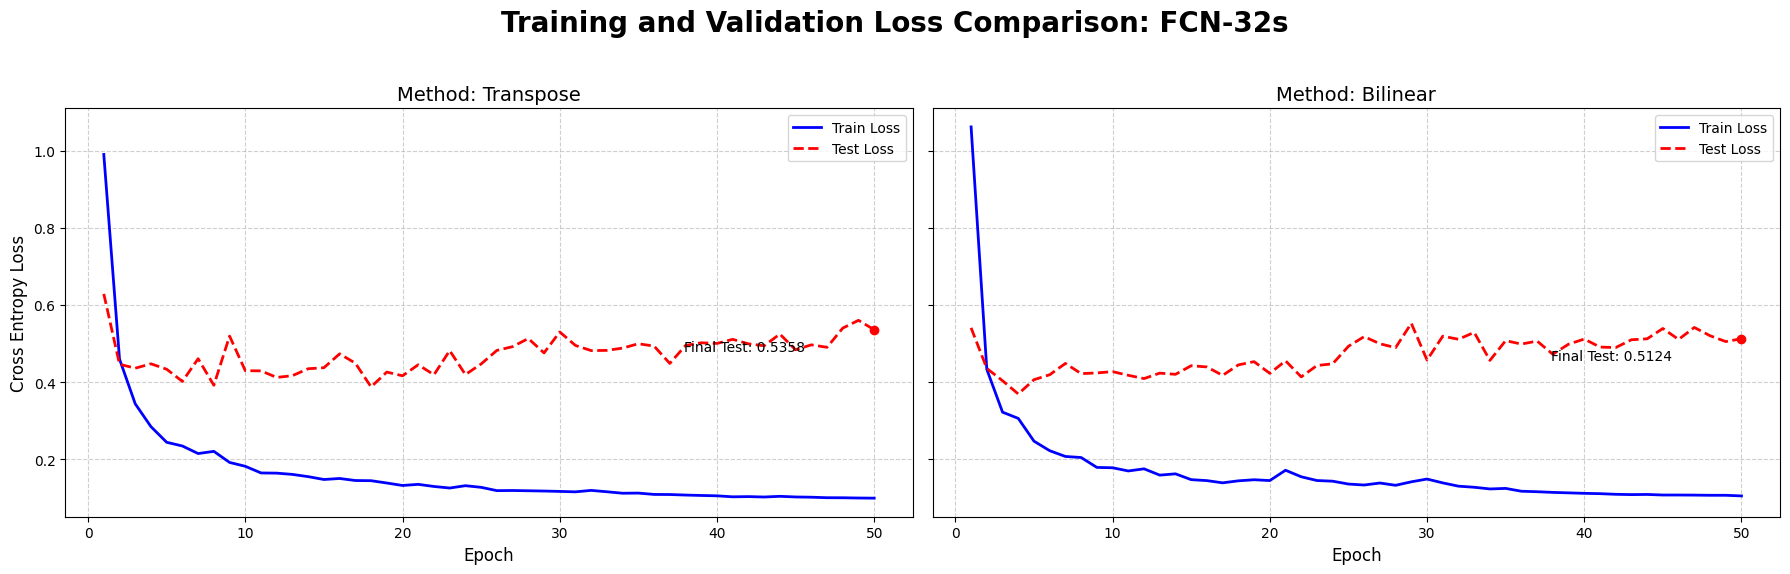

In [59]:
plot_comparison_curves(results)

1. **Training Loss**
In both upsampling methods, the training loss decreases steadily and smoothly.
This indicates that the model is learning stable feature representations.

2. **Validation Loss**
In both upsampling methods validation loss stabilizes relatively early (around epoch 5–10), but remains significantly higher than the training loss and shows oscillations throughout the training.
This can suggests overfitting, which can be expected due to a small dataset.

Both upsampling methods behave almost identically, indicating that type of upsampling method doesn't cause this problem.

### mIoU and Pixel Accuracy validation curves

In [75]:
def plot_comparison_metrics(results, model_name="FCN-32s"):
    
    upsampling_methods = ['transpose', 'bilinear']
    
    metrics_to_plot = [
        ('val_iou', 'Mean IoU', 'IoU'),
        ('val_acc', 'Pixel Accuracy', 'Accuracy')
    ]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10), sharex=True, sharey='row')
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    fig.suptitle(f'Comparative Segmentation Metrics: {model_name}', 
                 fontsize=20, fontweight='bold')

    for col_idx, method in enumerate(upsampling_methods):
        key = f"{model_name}_{method}"
        
        if key not in results:
            print(f"Warning: Results for {key} not found.")
            continue
            
        history = results[key]
        
        for row_idx, (val_key, y_label, title_suffix) in enumerate(metrics_to_plot):
            
            data_val = history.get(val_key, [])
            
            epochs = range(1, len(history.get('train_loss', [])) + 1)
            ax = axes[row_idx, col_idx] 
        
            ax.plot(epochs, data_val, 
                    label=f'Validation {title_suffix}', 
                    color='red', 
                    linestyle='-', 
                    linewidth=2)
        
            if row_idx == 0:
                ax.set_title(f"Method: {method.capitalize()}", fontsize=15, fontweight='bold')
            
            if data_val:
                final_val = data_val[-1]
                ax.annotate(f'Final: {final_val:.4f}', 
                            (epochs[-1], final_val), 
                            textcoords="offset points", xytext=(-50, 5), ha='right', fontsize=10)

            ax.set_ylabel(y_label, fontsize=12)
            if row_idx == 1: 
                ax.set_xlabel("Epoch", fontsize=12)
            
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.legend(loc='lower right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

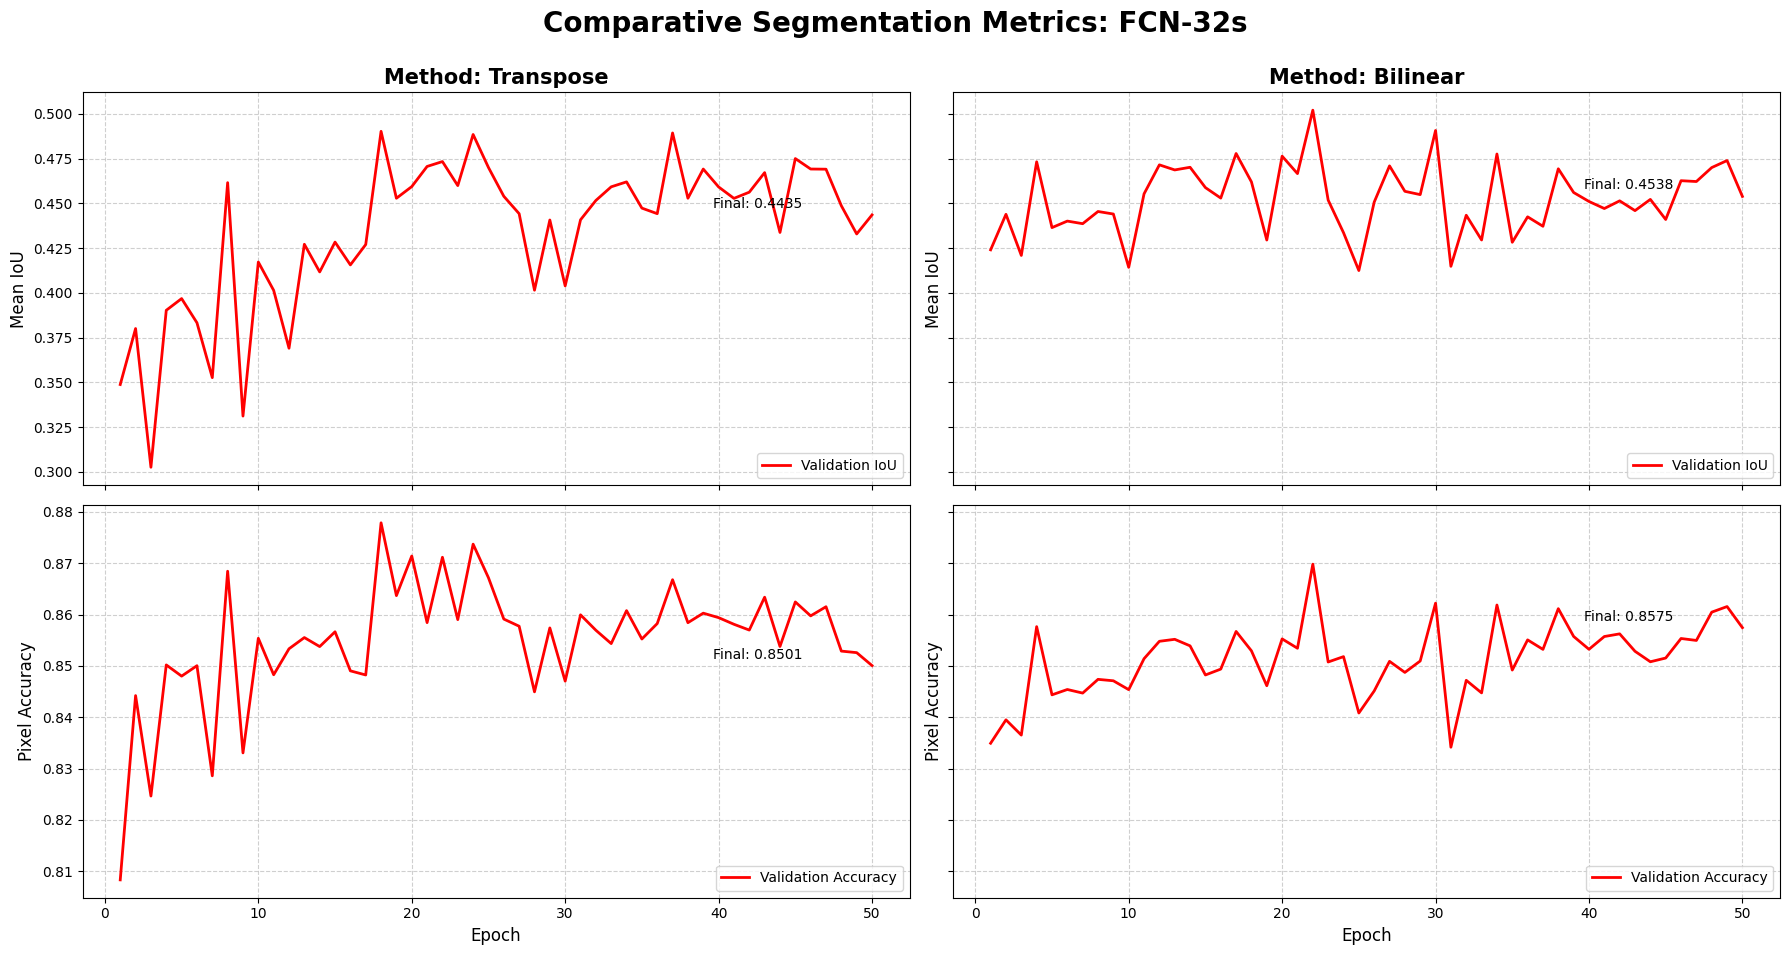

In [76]:
plot_comparison_metrics(results)

Both the Mean IoU and Pixel Accuracy curves exhibited high volatility throughout the 50 epochs, which is characteristic of training on a small dataset. However, the Bilinear Interpolation method maintained a slightly smoother trajectory and ultimately finished with a marginally better performance in both metrics compared to the Transpose Convolution. This indicates that for limited data, the stability of the fixed Bilinear filter was more beneficial than the complexity of the learnable Transpose layer.

# Predicted masks visualization

In [77]:

def pascal_color_map(N=256):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)
    cmap = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7 - j)
            g = g | (bitget(c, 1) << 7 - j)
            b = b | (bitget(c, 2) << 7 - j)
            c = c >> 3
        cmap[i] = np.array([r, g, b])
    return cmap

VOC_COLORMAP = pascal_color_map(256)

def get_denormalizer():
    return T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                       std=[1/0.229, 1/0.224, 1/0.225])

def load_single_model_instance(model_class, method, num_classes, device, model_arch_name):
    
    model_name_key = f"{model_arch_name}_{method}.pth"
    weights_path = f"FCN_models/{model_arch_name}_{method}.pth"

    try:
        model = model_class(num_classes=num_classes, upsampling=method).to(device)
        model.load_state_dict(torch.load(weights_path, map_location=device))
        model.eval()
        return model
    except Exception as e:
        print(f"ERROR: Could not load {model_name_key} from {weights_path}. Check file/class names.")
        return None


def visualize_upsampling_comparison_auto(test_ds, model_class, num_classes, device, test_indices, model_arch_name):
   
    denormalize = get_denormalizer()
    
    model_transpose = load_single_model_instance(model_class, 'transpose', num_classes, device, model_arch_name)
    model_bilinear = load_single_model_instance(model_class, 'bilinear', num_classes, device, model_arch_name)
    
    if model_transpose is None or model_bilinear is None:
        print("Cannot proceed with comparison. One or both models failed to load.")
        return

    models_to_compare = {
        'Transpose': model_transpose, 
        'Bilinear': model_bilinear
    }

    for img_idx, ds_index in enumerate(test_indices):
        
        img_tensor, mask_tensor = test_ds[ds_index]
        img_input = img_tensor.unsqueeze(0).to(device)
        input_img_np = np.clip(denormalize(img_tensor).permute(1, 2, 0).cpu().numpy(), 0, 1)
        gt_mask_colored = VOC_COLORMAP[mask_tensor.cpu().numpy()]

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
        fig.suptitle(f"Segmentation Comparison: {model_arch_name} | Test Image #{img_idx+1}", 
                     fontsize=16, 
                     y=1.05)
        
        axes[0].imshow(input_img_np); axes[0].set_title("1. Input Image"); axes[0].axis('off')
        axes[1].imshow(gt_mask_colored); axes[1].set_title("2. Ground Truth"); axes[1].axis('off')

        for col_idx, (method_name, model) in enumerate(models_to_compare.items()):
            
            with torch.no_grad():
                output = model(img_input)
                output = F.interpolate(output, size=mask_tensor.shape, mode='bilinear', align_corners=False)
                pred_mask = output.squeeze().argmax(0).cpu().numpy()
            
            pred_mask_colored = VOC_COLORMAP[pred_mask]
            
            ax = axes[col_idx + 2] 
            ax.imshow(pred_mask_colored)
            ax.set_title(f"{col_idx+3}. Pred: {method_name}", fontsize=12, color='darkgreen' if method_name=='Bilinear' else 'darkred')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

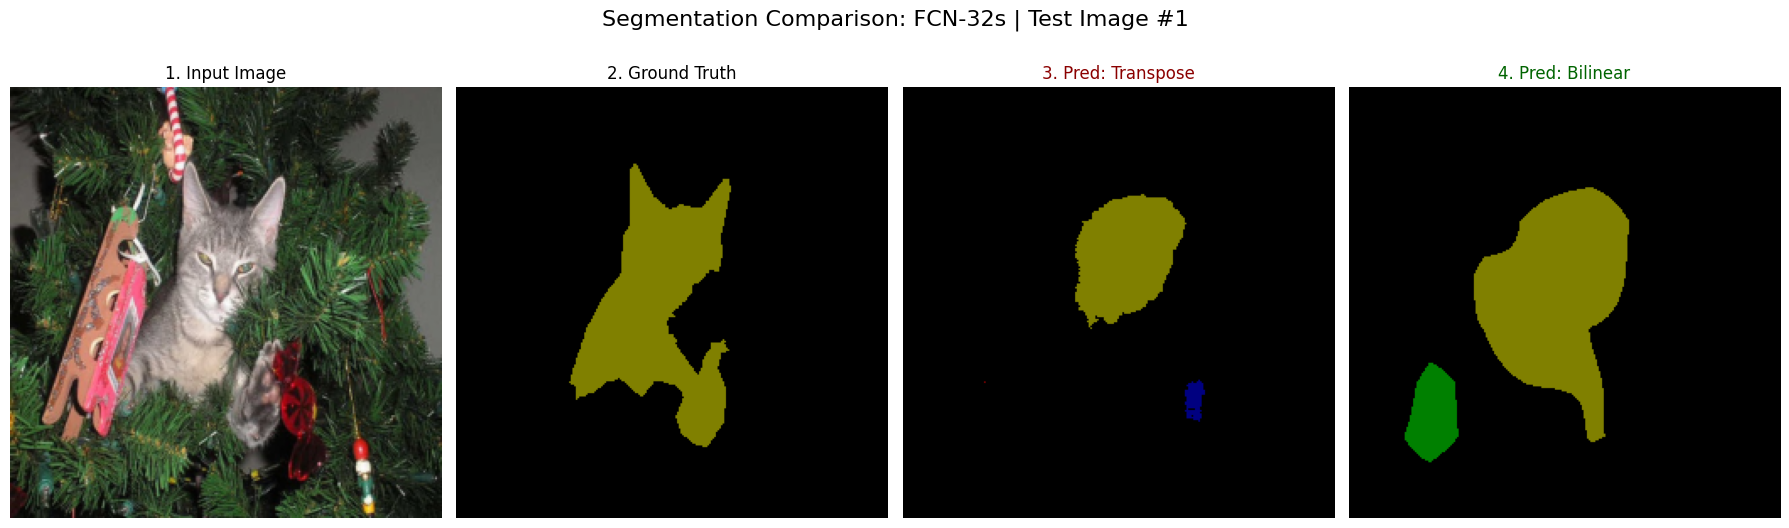

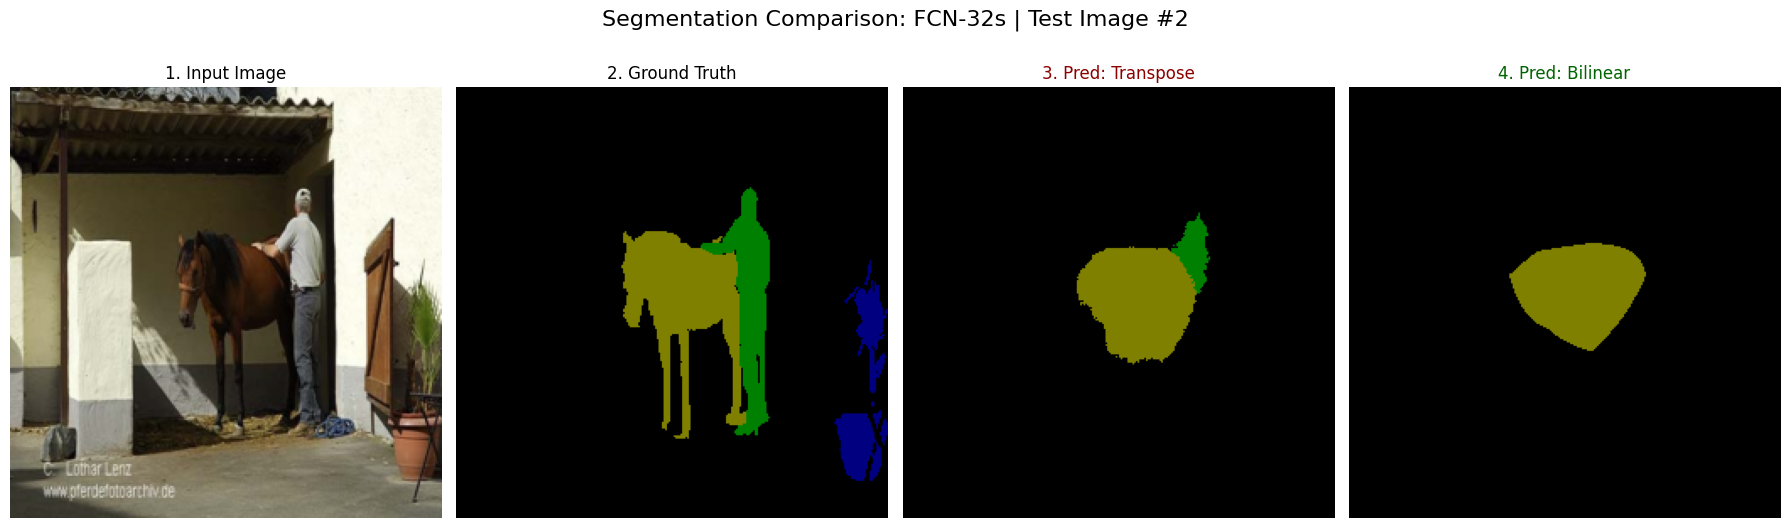

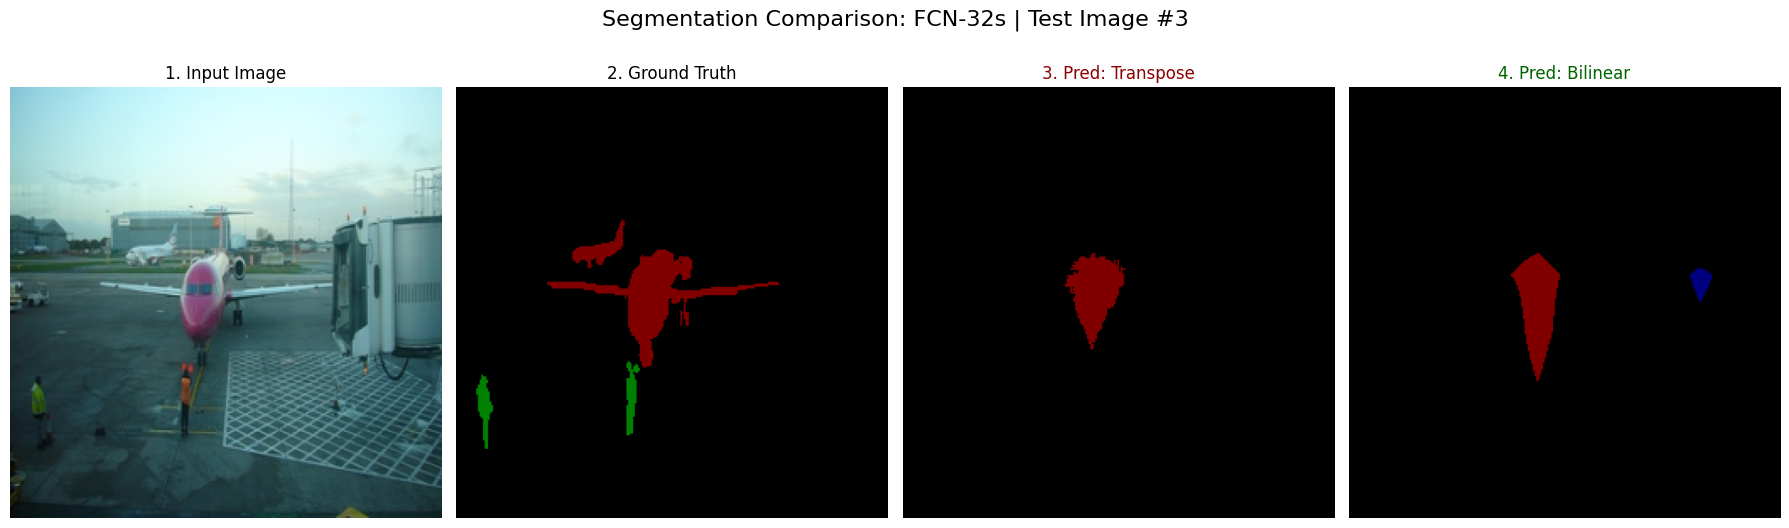

In [78]:
TEST_INDICES_TO_SHOW = [0, 1, 2] 
WEIGHTS_PATH_TEMPLATE = "FCN_models/{model_name}_{method}.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

visualize_upsampling_comparison_auto(
    test_ds=test_dataset, 
    model_class=FCN32s, 
    num_classes=NUM_CLASSES, 
    device=DEVICE,  
    test_indices=TEST_INDICES_TO_SHOW,
    model_arch_name="FCN-32s" 
)

Both models are visually imperfect due to the small dataset size and it's hard to say which one creates more accurate masks. The Bilinear Interpolation method tends to produce smoother and more coherent main object masks. On the other hand, the Transpose Convolution model demonstrates better ability to differentiate multiple foreground classes (for example Image #2). 

In [ ]:
def evaluate_fcn_models(test_dataloader, model_class_ref, model_arch_name, num_classes, device, upscale_methods, saved_weights_path_template):
    
    results = {}

    for method in upscale_methods:
        key = f"{model_arch_name} ({method.capitalize()})"
        
        weights_path = saved_weights_path_template.format(model_name=model_arch_name, method=method)
        
        print(f"-> Evaluating {key}...")

        try:
            model = model_class_ref(num_classes=num_classes, upsampling=method).to(device)
            model.load_state_dict(torch.load(weights_path, map_location=device))
            model.eval() 

            all_outputs = []
            all_targets = []
            
            with torch.no_grad():
                for inputs, masks in tqdm(test_dataloader, desc=f"Test set for {key}"): 
                    inputs, masks = inputs.to(device), masks.to(device)

                    outputs = model(inputs)
                    
                    outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

                    all_outputs.append(outputs.cpu())
                    all_targets.append(masks.cpu())

            outputs_tensor = torch.cat(all_outputs, dim=0)
            targets_tensor = torch.cat(all_targets, dim=0)
            pixel_acc, mean_iou = compute_metrics(outputs_tensor, targets_tensor, num_classes)

            results[key] = {
                "Model": model_arch_name,
                "Upsampling": method.capitalize(),
                "Mean IoU (Test)": mean_iou,
                "Pixel Accuracy (Test)": pixel_acc
            }

        except FileNotFoundError:
            print(f"Weights file not found for {key} at {weights_path}. Skipping.")
        except Exception as e:
            print(f"An error occurred during evaluation of {key}: {e}")
            
    return pd.DataFrame(list(results.values()))

In [ ]:
df_comparison_report = evaluate_fcn_models(
    test_dataloader=test_dataloader, 
    model_class_ref=FCN32s,
    model_arch_name="FCN-32s",
    num_classes=NUM_CLASSES, 
    device=DEVICE, 
    upscale_methods=UPSCALE_METHODS,
    saved_weights_path_template=WEIGHTS_PATH_TEMPLATE
)

print("\n\n--- FINAL COMPARISON TABLE (Mean IoU & Accuracy) ---")
display(df_comparison_report)

-> Evaluating FCN-32s (Transpose)...


Test set for FCN-32s (Transpose): 100%|██████████| 15/15 [00:00<00:00, 86.03it/s]


-> Evaluating FCN-32s (Bilinear)...


Test set for FCN-32s (Bilinear): 100%|██████████| 15/15 [00:00<00:00, 87.46it/s]




--- FINAL COMPARISON TABLE (Mean IoU & Accuracy) ---


,Model,Upsampling,Mean IoU (Test),Pixel Accuracy (Test)
0,FCN-32s,Transpose,0.511647,0.886592
1,FCN-32s,Bilinear,0.514471,0.884923


**Pixel Accuracy** is very simple metric, defined as the ratio of the total number of correctly classified pixels (both object and background) to the total number of pixels in the image.

**Mean Intersection over Union (Mean IoU)** is the standard metric for semantic segmentation tasks. IoU is the ratio of the area of overlap (intersection) between the predicted segmentation and the ground truth to the area of union (the combined area of both). Mean IoU averages this score across all classes. It severely penalizes misclassification of boundaries and smaller objects. A high Mean IoU indicates excellent boundary localization and true precision for every object class.

### Results:
**Mean IoU**
Both models achieve ~0.51 IoU, which is decent for a small, unbalanced dataset.
The difference between Transpose and Bilinear is negligible (<0.003), meaning that both methods segment at almost identical quality.

**Pixel Accuracy**
Pixel accuracy is high (~0.88), but this metric is not very precise, as large background regions dominate the image and therefore high accuracy can hide poor object segmentation.

The final metrics demonstrated that the Bilinear Interpolation method very slightly outperformed the Transpose Convolution method on the test dataset in terms of mIoU metric.
Furthermore, the training curves showed that both models were prone to overfitting due to small and unbalanced dataset.

**Transpose Convolution** is designed to be superior because its filters are learnable, leading to sharper boundaries. However, this superior performance requires a larger volume of data to optimize the high number of transpose filters' weights. Ultimately, the simplicity and stability of the **Bilinear method** proved more robust against the training instability caused by the small dataset, providing a better starting point and final result.